# BioLab API Demo (BioLab container)

In [28]:
import sys

sys.path.insert(0, '..')

#### **_Experiment 1_**:  Here we cross a boundary in the stack that is a biological simulation. We go from model configuration, to experiment. Thus, this tooling sits at that level: both experiment specification AND experiment execution. It's not just a way to specify an experiment, but it is also a way to run it, given the many knobs and buttons that you can use predefine and customize the way the actual model is being solved. Our users are seeking to be involved in an experiment as a "stack". We should make a bigger distinction between terms like "model".

In [2]:
from process_bigraph import pp
from biosimulator_processes.biosimulator_builder import BuildPrompter
from biosimulator_processes import SedDataModel as sed 

CobraProcess registered successfully.
CopasiProcess registered successfully.
SmoldynProcess registered successfully.
TelluriumProcess registered successfully.


In [3]:
# 1a. define a model for the process composition. In this case, just one model to be re-used as configuration for the processes we create:

simple_tc_model = sed.TimeCourseModel(model_source=tumor_control_biomodel_id)

pp(simple_tc_model)

TimeCourseModel(model_source='BIOMD0000000749',
                model_id='model_from_BIOMD0000000749',
                model_name='model_from_BIOMD0000000749',
                model_language=(None,),
                model_changes=None,
                model_units=None)


In [27]:
# 1b. view model info for model source:

pp(simple_tc_model.source_info)

{ 'description': 'The paper describes a model of tumor control via alternating '
                 'immunostimulating and immunosuppressive phases. \r\n'
                 'Created by COPASI 4.25 (Build 207) \r\n'
                 '\r\n'
                 'This model is described in the article: \r\n'
                 'In silico tumor control induced via alternating '
                 'immunostimulating and immunosuppressive phases\r\n'
                 'AI Reppas, JCL Alfonso, and H Hatzikirou\r\n'
                 'Virulence 7:2, 174--186\r\n'
                 '\r\n'
                 'Abstract: \r\n'
                 'Despite recent advances in the field of Oncoimmunology, the '
                 'success potential of immunomodulatory therapies against '
                 'cancer remains to be elucidated. One of the reasons is the '
                 'lack of understanding on the complex interplay between tumor '
                 'growth dynamics and the associated immune system responses.

In [4]:
# 1c. define a TimeCourse process instance using the above object as a parameter. The other parameter is method. See BasiCO documentation for more details on solvers

simple_tc_process = sed.TimeCourseProcess(model=simple_tc_model, method='lsoda')

In [5]:
# >> The process model instance is viewable as a dataclass...

pp(simple_tc_process)

TimeCourseProcess(model=TimeCourseModel(model_source='BIOMD0000000749',
                                        model_id='model_from_BIOMD0000000749',
                                        model_name='model_from_BIOMD0000000749',
                                        model_language=(None,),
                                        model_changes=None,
                                        model_units=None),
                  method='lsoda')


In [6]:
# >> ...or a dict:

pp(simple_tc_process.to_dict())

{ 'method': 'lsoda',
  'model': { 'model_changes': None,
             'model_id': 'model_from_BIOMD0000000749',
             'model_language': (None,),
             'model_name': 'model_from_BIOMD0000000749',
             'model_source': 'BIOMD0000000749',
             'model_units': None}}


In [7]:
# 2. instantiate the prompter:

prompter = BuildPrompter()

In [8]:
# 3. add process(es) to the bigraph with the Time Course model instance we created above. For now, just one process will be added.

prompter.add_single_process(config=simple_tc_process)

simple process successfully added to the bi-graph!
All nodes including the most recently added simple processes connected!
Done adding single simple (CopasiProcess) to the bigraph.


In [9]:
# 4. Inspect the builder instance within prompter:

pp(prompter.builder_instance)

Builder({ 'emitter': { '_type': 'step',
               'address': 'local:ram-emitter',
               'config': {'emit': {}},
               'inputs': {},
               'instance': <process_bigraph.composite.RAMEmitter object at 0x2913d7130>,
               'outputs': {}},
  'simple': { '_type': 'process',
              'address': 'local:CopasiProcess',
              'config': { 'method': 'lsoda',
                          'model': { 'model_changes': { 'global_parameter_changes': None,
                                                        'reaction_changes': None,
                                                        'species_changes': None},
                                     'model_id': 'model_from_BIOMD0000000749',
                                     'model_language': (None,),
                                     'model_name': 'model_from_BIOMD0000000749',
                                     'model_source': 'BIOMD0000000749',
                                     'model_unit

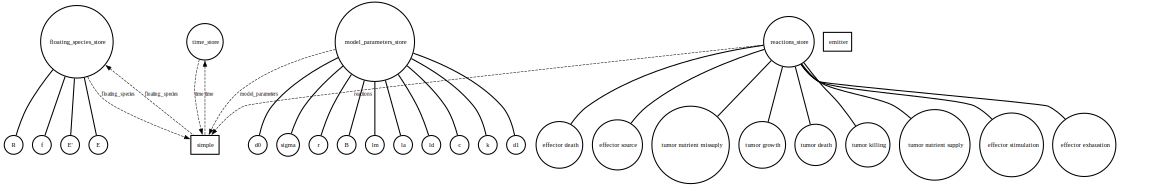

In [10]:
# 5. Visualize the fully-connected composition:

prompter.visualize_bigraph()

In [11]:
# 6. Generate a composite engine and use to execute the bigraph that we just created:

prompter.run()

Error while running the simulation: >ERROR 2024-03-15T16:13:39<
  CCopasiTask (5): No output file defined for report of task 'Time-Course'.>EXCEPTION 2024-03-15T16:13:39<
  CTrajectoryMethod (25): Invalid state at time '0.010000'.


Generating composite...
Composite generated!
Running generated composite for an interval of 1
Composite successfully run. Request complete. Done.


/Users/alex/Desktop/uchc_work/repos/biosimulator-processes/notebooks/../biosimulator_processes/processes/copasi_process.py:231: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [12]:
# 7. Clear the builder and start from scratch, writing it out first:

prompter.flush(fp='simple_single_demo')

File 'simple_single_demo' successfully written in 'out' directory.
Builder flushed! This is verified because builder is: None


In [13]:
prompter.builder_instance

#### **_Experiment 2_**: Load an SBML model from a specified model filepath and add Model changes to the composite before adding it to the bigraph. Here, we expect the user to be familiar enough with the model file they are passing to make individual species/parameter/reaction changes for specific species types. In the Caravagna model, for example, the species involved are T, E, I. Let's change the initial concentration for some of these as an example of model changes:

In [26]:
caravagna_model_filepath = '../biosimulator_processes/model_files/Caravagna2010.xml'
print(os.path.exists(caravagna_model_filepath))

True


In [16]:
# first make the timecourse model which is easily configured with objects related to model changes
adjusted_tc_model_from_file = sed.TimeCourseModel(
    model_source=caravagna_model_filepath, 
    model_changes=sed.TimeCourseModelChanges(
        species_changes=sed.SpeciesChange(species_name='T', initial_concentration=0.234)
    )
)


pp(adjusted_tc_model_from_file)

TimeCourseModel(model_source='../biosimulator_processes/model_files/Caravagna2010.xml',
                model_id='model_from_Caravagna2010.xml',
                model_name='model_from_Caravagna2010.xml',
                model_language=TimeCourseModelChanges(species_changes=SpeciesChange(species_name='T',
                                                                                    unit=None,
                                                                                    initial_concentration=0.234,
                                                                                    initial_particle_number=None,
                                                                                    initial_expression=None,
                                                                                    expression=None),
                                                      global_parameter_changes=None,
                                                      reaction_changes=None)

In [18]:
adjusted_tc_process = sed.TimeCourseProcess(model=adjusted_tc_model_from_file, method='stochastic')

pp(adjusted_tc_process)

TimeCourseProcess(model=TimeCourseModel(model_source='../biosimulator_processes/model_files/Caravagna2010.xml',
                                        model_id='model_from_Caravagna2010.xml',
                                        model_name='model_from_Caravagna2010.xml',
                                        model_language=TimeCourseModelChanges(species_changes=SpeciesChange(species_name='T',
                                                                                                            unit=None,
                                                                                                            initial_concentration=0.234,
                                                                                                            initial_particle_number=None,
                                                                                                            initial_expression=None,
                                                                       

In [21]:
# add the process we just created with the prompter. The prompter will create a new instance of builder for us, if not passed:

prompter.add_single_process(config=adjusted_tc_process)

adjusted_tc_process_demo process successfully added to the bi-graph!
All nodes including the most recently added adjusted_tc_process_demo processes connected!
Done adding single adjusted_tc_process_demo (CopasiProcess) to the bigraph.


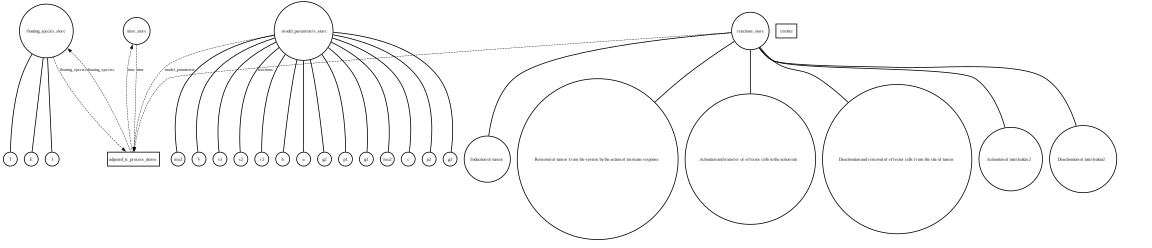

In [22]:
# visualize the adjusted creation

prompter.visualize_bigraph()

In [23]:
# view the builder document

prompter.builder_instance.document()

{'emitter': {'_type': 'step',
  'address': 'local:ram-emitter',
  'config': {'emit': {}},
  'inputs': {},
  'outputs': {}},
 'adjusted_tc_process_demo': {'_type': 'process',
  'address': 'local:CopasiProcess',
  'config': {'model': {'model_source': '../biosimulator_processes/model_files/Caravagna2010.xml',
    'model_id': 'model_from_Caravagna2010.xml',
    'model_name': 'model_from_Caravagna2010.xml',
    'model_language': {'species_changes': {'species_name': 'T',
      'unit': None,
      'initial_concentration': 0.234,
      'initial_particle_number': None,
      'initial_expression': None,
      'expression': None},
     'global_parameter_changes': None,
     'reaction_changes': None},
    'model_changes': {'species_changes': None,
     'global_parameter_changes': None,
     'reaction_changes': None},
    'model_units': None},
   'method': 'stochastic'},
  'inputs': {'time': ['time_store'],
   'floating_species': ['floating_species_store'],
   'model_parameters': ['model_parameters

In [24]:
# run the composite

prompter.run()

Generating composite...
Composite generated!
Running generated composite for an interval of 30
Composite successfully run. Request complete. Done.


/Users/alex/Desktop/uchc_work/repos/biosimulator-processes/notebooks/../biosimulator_processes/processes/copasi_process.py:231: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [25]:
# stochastic works with Caravagna!!